# Case Study 1: Predective Maintenance

## Objectives

After this tutorial you will be able to:

*   Link all the steps of a typical data science project
*   Predict maintenance time for a device based on historical data

<h2>Table of Contents</h2>

<ol>
    <li>
        <a href="#problem">Problem Definition</a>
    </li>
    <br>
    <li>
        <a href="#import">Data Collection</a>
    </li>
    <br>
    <li>
        <a href="#clean">Data Cleaning and Preparation</a>
    </li>
    <br>
    <li>
        <a href="#eda">Exploratory Data Analysis</a>
    </li>
    <br>
    <li>
        <a href="#model">Model Development and Evaluation</a>
    </li>
    <br>
    <li>
        <a href="#deploy">Deployment and Communication</a>
    </li>
    <br>
</ol>


<hr id="problem">

<h2>1. Problem Definition</h2>

<h3>Background:</h3>

Operation data was provided by a refinery. The data reflect information about heat exchangers in a cold train serving a crude distillation unit in the refinery.  
The network consists of 7 countercurrent heat exchangers where raw crude is in the tube side of each exchanger.  

<div style="text-align: center;">
    <img src="hex_network.png" height="500px">
</div>

<h3>Data</h3>

The data provided consists of monthly files with daily data for each heat exchanger. We will only work on exchanger `E-003` in this lab.  
Each file contains the following details:
- Date
- Flow rate (raw crude), bph
- Inlet temp (raw crude), F
- Outlet temp (raw crude), F
- Flow rate (VTB), bph
- Inlet temp (VTB), F
- Outlet temp (VTB), F

Process parameters:
- U (service), Btu/h.ft^2.F: 27.7
- Exchanger Area, ft^2: 3,561
- Cp (raw crude), Btu/lb.F: 2.6
- Cp (VTB), Btu/lb.F: 4
- Density (raw crude), lb/ft^3: 56.85
- Density (VTB), lb/ft^3: 65


<h3>Goal:</h3>

Making recommendations on heat exchanger cleaning schedule given that cleaning is necessary when `U (actual)` drops below `70% of U (service)`.


<hr id="import">

<h2>2. Data Collection</h2>

Import the `Pandas` library

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Read the data from `data.csv` into a `Pandas DataFrame`

In [2]:
# load all csv files in hex_data folder and concatenate them into one dataframe
folder = 'E003_data'
files = os.listdir(folder)
df = pd.DataFrame()
for file in files:
    df = pd.concat([df, pd.read_csv(folder + '/' + file)], axis=0, ignore_index=True)

df.head()


,Date,"Tube Flow Rate, bph","Tube Temp In, F","Tube Temp Out, F","Shell Flow Rate, bph","Shell Temp In, F","Shell Temp Out, F"
0,2021-01-01,1607.726079,68.0,90.0,2872.547153,376.0,369.0
1,2021-01-02,1699.271821,90.0,109.0,2294.335572,383.0,375.0
2,2021-01-03,1499.373830,96.0,118.0,2083.629832,416.0,407.0
3,2021-01-04,2895.661064,80.0,92.0,2194.911086,425.0,416.0
4,2021-01-05,3539.864482,88.0,98.0,2874.875654,388.0,381.0


<hr id="clean">

<h2>3. Data Cleaning and Preparation</h2>

<h5 id="clean-missing">Handle missing values</h5>

Identify missing values

In [3]:
# get more info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1071 entries, 0 to 1070
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1071 non-null   object 
 1   Tube Flow Rate, bph   1070 non-null   float64
 2   Tube Temp In, F       1069 non-null   float64
 3   Tube Temp Out, F      1068 non-null   float64
 4   Shell Flow Rate, bph  1069 non-null   float64
 5   Shell Temp In, F      1069 non-null   float64
 6   Shell Temp Out, F     1068 non-null   float64
dtypes: float64(6), object(1)
memory usage: 58.7+ KB


In [4]:
# find the number of missing values in each column
df.isna().sum()

Date                    0
Tube Flow Rate, bph     1
Tube Temp In, F         2
Tube Temp Out, F        3
Shell Flow Rate, bph    2
Shell Temp In, F        2
Shell Temp Out, F       3
dtype: int64

Drop rows with "NaN" from certain columns

In [5]:
# drop the rows with missing values
df.dropna(inplace=True)
df.head()

,Date,"Tube Flow Rate, bph","Tube Temp In, F","Tube Temp Out, F","Shell Flow Rate, bph","Shell Temp In, F","Shell Temp Out, F"
0,2021-01-01,1607.726079,68.0,90.0,2872.547153,376.0,369.0
1,2021-01-02,1699.271821,90.0,109.0,2294.335572,383.0,375.0
2,2021-01-03,1499.373830,96.0,118.0,2083.629832,416.0,407.0
3,2021-01-04,2895.661064,80.0,92.0,2194.911086,425.0,416.0
4,2021-01-05,3539.864482,88.0,98.0,2874.875654,388.0,381.0


<h5 id="clean-duplicates">Remove duplicates</h5>

In [6]:
# find the number of duplicate rows
df.duplicated().sum()

3

In [7]:
# drop the duplicate rows
df.drop_duplicates(inplace=True)
df

,Date,"Tube Flow Rate, bph","Tube Temp In, F","Tube Temp Out, F","Shell Flow Rate, bph","Shell Temp In, F","Shell Temp Out, F"
0,2021-01-01,1607.726079,68.0,90.0,2872.547153,376.0,369.0
1,2021-01-02,1699.271821,90.0,109.0,2294.335572,383.0,375.0
2,2021-01-03,1499.373830,96.0,118.0,2083.629832,416.0,407.0
3,2021-01-04,2895.661064,80.0,92.0,2194.911086,425.0,416.0
4,2021-01-05,3539.864482,88.0,98.0,2874.875654,388.0,381.0
...,...,...,...,...,...,...,...
1066,2023-11-30,1177.558188,75.0,97.0,1840.965032,372.0,364.0
1067,2023-11-27,1528.450586,88.0,114.0,3056.901172,413.0,411.0
1068,2023-11-28,1107.331654,112.0,122.0,2214.663308,369.0,360.0
1069,2023-11-29,1256.092199,89.0,103.0,2512.184398,375.0,368.0


<h5 id="clean-standardize">Standardize data</h5>

In [8]:
# convert column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# convert the rest of the columns to float
df.iloc[:, 1:] = df.iloc[:, 1:].astype(float)

<h5>Validate cleaned data</h5>

In [9]:
# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1055 entries, 0 to 1070
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  1055 non-null   datetime64[ns]
 1   Tube Flow Rate, bph   1055 non-null   float64       
 2   Tube Temp In, F       1055 non-null   float64       
 3   Tube Temp Out, F      1055 non-null   float64       
 4   Shell Flow Rate, bph  1055 non-null   float64       
 5   Shell Temp In, F      1055 non-null   float64       
 6   Shell Temp Out, F     1055 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 65.9 KB


In [10]:
# check for duplicates
df.duplicated().sum()

0

<h5>Create extra required features</h5>

-  `year-month`
-  `LMTD`
-  `U (actual)`

In [11]:
# create a new column for "year-month" (yyyy-mm)
df['year-month'] = df['Date'].dt.strftime('%Y-%m')

# create a new column for "LMTD"
df['LMTD'] = ((df['Shell Temp In, F'] - df['Tube Temp Out, F']) - (df['Shell Temp Out, F'] - df['Tube Temp In, F'])) / np.log((df['Shell Temp In, F'] - df['Tube Temp Out, F']) / (df['Shell Temp Out, F'] - df['Tube Temp In, F']))

# create a new column for "U (actual)" = Q / (A * LMTD) = V * rho * Cp * dT / (A * LMTD)
df['U (actual)'] = df['Tube Flow Rate, bph'] * 5.615 * 56.85 * 2.6 * (df['Tube Temp Out, F'] - df['Tube Temp In, F']) / (3561 * df['LMTD'])

df.head()

,Date,"Tube Flow Rate, bph","Tube Temp In, F","Tube Temp Out, F","Shell Flow Rate, bph","Shell Temp In, F","Shell Temp Out, F",year-month,LMTD,U (actual)
0,2021-01-01,1607.726079,68.0,90.0,2872.547153,376.0,369.0,2021-01,293.436105,28.093302
1,2021-01-02,1699.271821,90.0,109.0,2294.335572,383.0,375.0,2021-01,279.463920,26.926029
2,2021-01-03,1499.373830,96.0,118.0,2083.629832,416.0,407.0,2021-01,304.453744,25.251832
3,2021-01-04,2895.661064,80.0,92.0,2194.911086,425.0,416.0,2021-01,334.497758,24.211259
4,2021-01-05,3539.864482,88.0,98.0,2874.875654,388.0,381.0,2021-01,291.497427,28.303068


<hr id="eda">

<h2>4. Exploratory Data Analysis</h2>

<h5>Descriptive Analysis</h5>

In [12]:
df_desc = df.describe()
df_desc

,Date,"Tube Flow Rate, bph","Tube Temp In, F","Tube Temp Out, F","Shell Flow Rate, bph","Shell Temp In, F","Shell Temp Out, F",LMTD,U (actual)
count,1055,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000
mean,2022-06-17 22:38:06.255924480,1944.237145,87.303318,104.667299,2303.328135,396.054028,388.277725,296.144209,24.146632
min,2021-01-01 00:00:00,864.211243,40.000000,80.000000,1395.872047,310.000000,300.000000,201.499586,-16.255192
25%,2021-09-23 12:00:00,1418.001747,78.000000,96.000000,2024.665390,380.000000,372.000000,279.475848,22.507430
50%,2022-06-18 00:00:00,1765.041748,88.000000,105.000000,2281.302502,396.000000,389.000000,295.497462,24.122573
75%,2023-03-11 12:00:00,2337.571924,96.000000,114.000000,2598.816932,413.000000,405.000000,312.997338,25.866595
max,2023-11-30 00:00:00,4690.760258,140.000000,160.000000,3457.653031,490.000000,423.000000,349.431081,67.776602
std,NaN,674.850147,11.780928,10.531791,366.732594,19.681764,19.425223,22.517124,3.249439


<h5>Visualize Parameters and identify outliers</h5>

### Shell side

Box plot

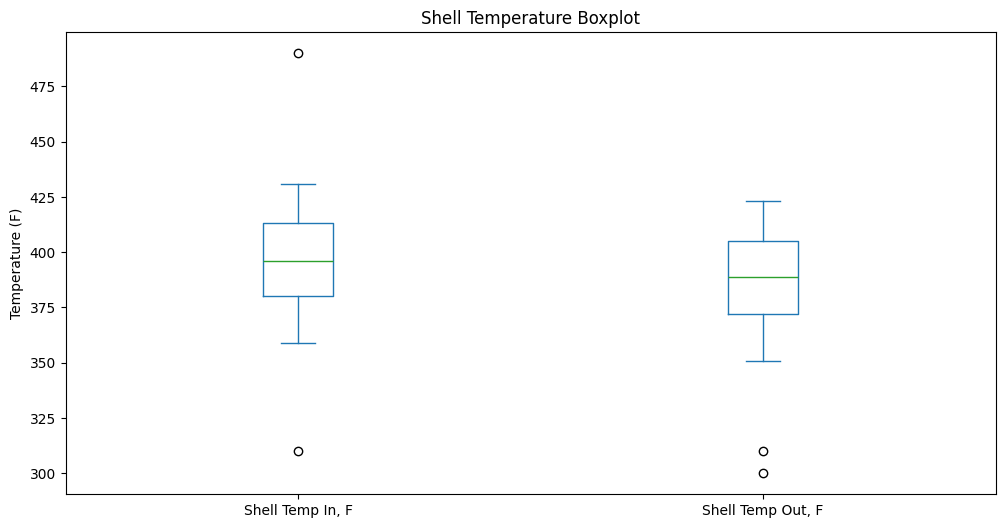

In [13]:
# box plot
df[['Shell Temp In, F', 'Shell Temp Out, F']].plot(kind='box', figsize=(12, 6), title='Shell Temperature Boxplot', ylabel='Temperature (F)')
plt.show()

Remove outliers

In [14]:
# remove outliers for "Shell Temp In, F" column
iqr = df_desc.loc['75%', 'Shell Temp In, F'] - df_desc.loc['25%', 'Shell Temp In, F']
upper_bound = df_desc.loc['75%', 'Shell Temp In, F'] + 1.5 * iqr
lower_bound = df_desc.loc['25%', 'Shell Temp In, F'] - 1.5 * iqr
df = df[(df['Shell Temp In, F'] < upper_bound) & (df['Shell Temp In, F'] > lower_bound)]

# remove outliers for "Shell Temp Out, F" column
iqr = df_desc.loc['75%', 'Shell Temp Out, F'] - df_desc.loc['25%', 'Shell Temp Out, F']
upper_bound = df_desc.loc['75%', 'Shell Temp Out, F'] + 1.5 * iqr
lower_bound = df_desc.loc['25%', 'Shell Temp Out, F'] - 1.5 * iqr
df = df[(df['Shell Temp Out, F'] < upper_bound) & (df['Shell Temp Out, F'] > lower_bound)]

Remove impractical entries

In [15]:
# find entries with "Shell Temp In, F" < "Shell Temp Out, F"
df[df['Shell Temp In, F'] < df['Shell Temp Out, F']]

,Date,"Tube Flow Rate, bph","Tube Temp In, F","Tube Temp Out, F","Shell Flow Rate, bph","Shell Temp In, F","Shell Temp Out, F",year-month,LMTD,U (actual)
179,2021-06-28,3636.575007,95.0,105.0,2297.103213,408.0,420.0,2021-06,313.871508,27.003637
577,2022-07-30,2835.343932,95.0,105.0,1790.992250,367.0,390.0,2022-07,278.173842,23.755877


In [16]:
# remove the found entries
df = df[df['Shell Temp In, F'] > df['Shell Temp Out, F']]
df.describe()

,Date,"Tube Flow Rate, bph","Tube Temp In, F","Tube Temp Out, F","Shell Flow Rate, bph","Shell Temp In, F","Shell Temp Out, F",LMTD,U (actual)
count,1050,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000,1050.000000
mean,2022-06-19 12:53:29.142857216,1941.955319,87.267619,104.642857,2303.454447,396.088571,388.382857,296.245589,24.130721
min,2021-01-01 00:00:00,864.211243,40.000000,80.000000,1395.872047,359.000000,351.000000,238.499651,-16.255192
25%,2021-09-26 06:00:00,1417.872118,78.000000,96.000000,2024.375036,380.000000,372.000000,279.492546,22.499237
50%,2022-06-19 12:00:00,1764.466964,88.000000,105.000000,2281.243739,396.000000,389.000000,295.712688,24.121286
75%,2023-03-12 18:00:00,2335.221950,96.000000,114.000000,2598.951858,413.000000,405.000000,312.994409,25.853235
max,2023-11-30 00:00:00,4690.760258,140.000000,160.000000,3457.653031,431.000000,423.000000,349.431081,67.776602
std,NaN,673.069774,11.796810,10.546238,366.878071,19.290039,19.089326,22.234814,3.237119


Tube Side


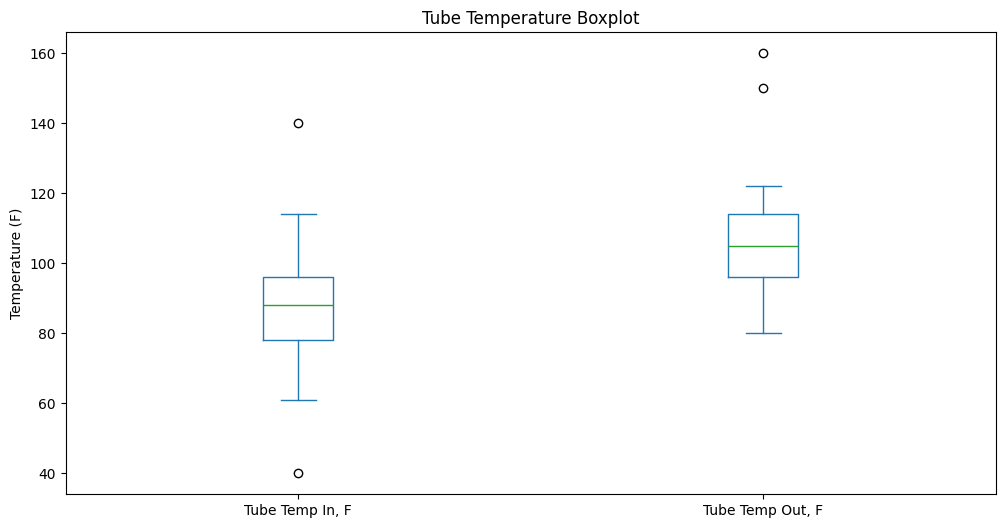

In [17]:
df[['Tube Temp In, F', 'Tube Temp Out, F']].plot(kind='box', figsize=(12, 6), title='Tube Temperature Boxplot', ylabel='Temperature (F)')
plt.show()

Flow Rates

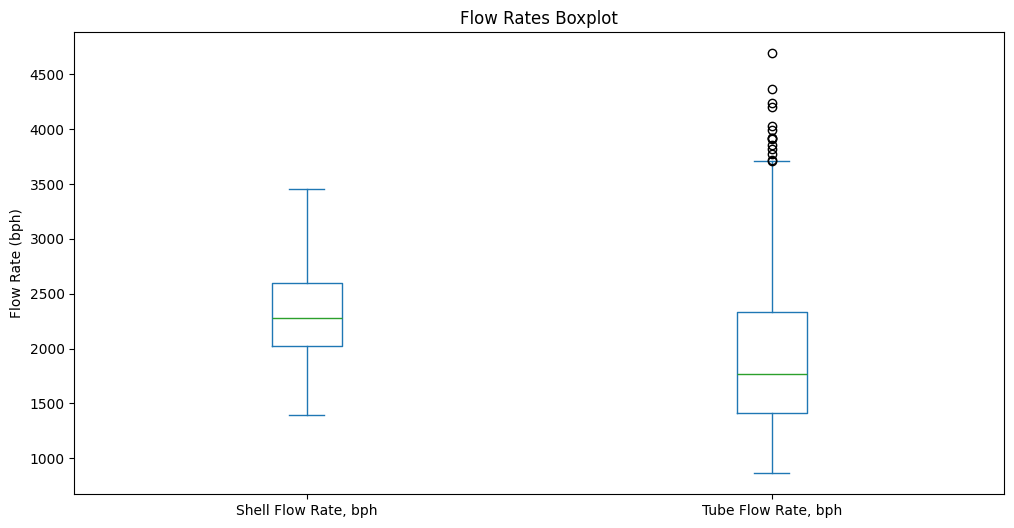

In [18]:
df[['Shell Flow Rate, bph', 'Tube Flow Rate, bph']].plot(kind='box', figsize=(12, 6), title='Flow Rates Boxplot', ylabel='Flow Rate (bph)')
plt.show()

<h5>Visualize trend of U over time</h5>

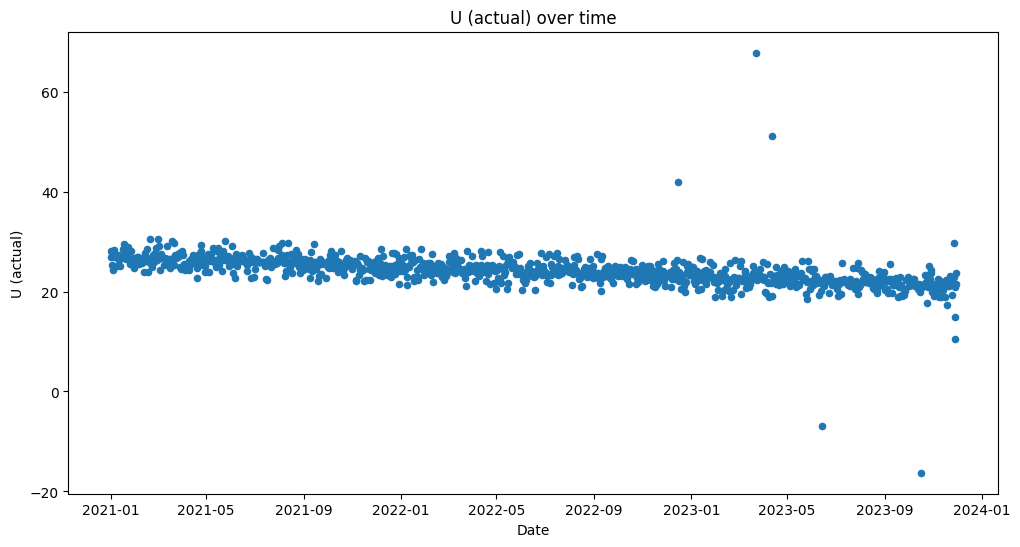

In [19]:
df.plot(kind='scatter', x='Date', y='U (actual)', figsize=(12, 6), title='U (actual) over time')
plt.show()

To decrease the noise, let's examine the average monthly values.

In [20]:
df_monthly = df.groupby('year-month', as_index=False)['U (actual)'].mean()
df_monthly


,year-month,U (actual)
0,2021-01,26.882875
1,2021-02,26.535819
2,2021-03,26.839704
3,2021-04,25.902595
4,2021-05,26.667200
5,2021-06,25.939044
6,2021-07,25.900940
7,2021-08,26.240308
8,2021-09,25.261704
9,2021-10,25.611380


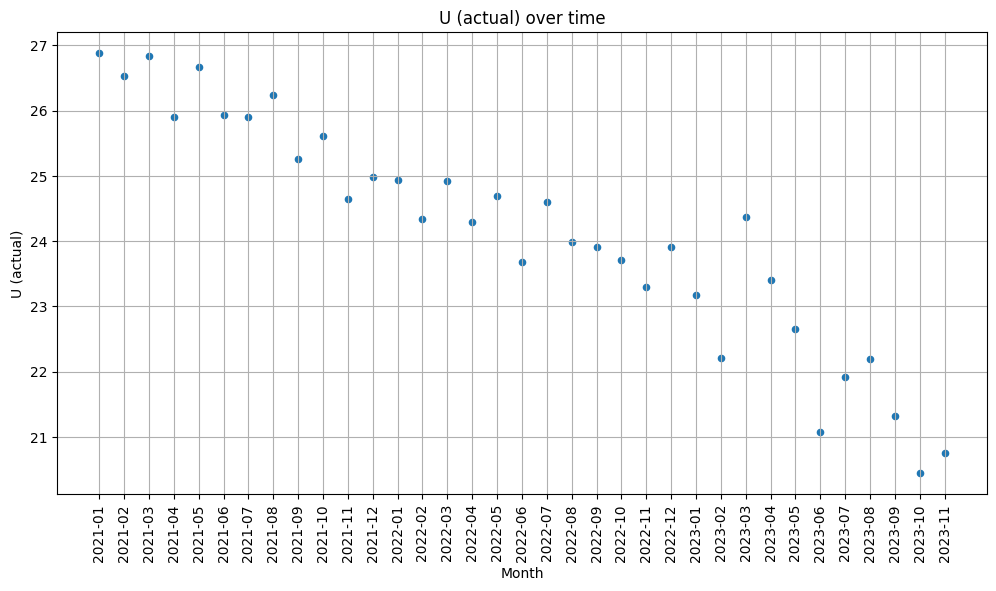

In [21]:
df_monthly.plot(kind='scatter', x='year-month', y='U (actual)', figsize=(12, 6), title='U (actual) over time')
plt.xlabel('Month')
plt.xticks(rotation=90)
plt.grid()
plt.show()

<hr id="model">

<h2>5. Model Development and Evaluation</h2>

Let's first try linear regression to fit `U (actual) vs Date`

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# create a linear regression model
lr = LinearRegression()

# split the data into training and testing sets
X = df_monthly.index.values.reshape(-1, 1)
Y = df_monthly['U (actual)']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# fit the model to the training data
lr.fit(X_train, y_train)

# make predictions using the testing set
y_pred = lr.predict(X_test)

# print the coefficients
print('Coefficients: \n', lr.coef_)
print('Intercept: \n', lr.intercept_)

Coefficients: 
 [-0.16444653]
Intercept: 
 26.91017590332744


Evaluate the linear model using the following metrics:
- Mean Squared Error (MSE)
- Coefficient of Determination (R2)

In [23]:
# evaluate the model
print('Mean squared error (MSE): {:.2f}'.format(mean_squared_error(y_test, y_pred)))
print('Coefficient of determination (R2): {:.2f}'.format(r2_score(y_test, y_pred)))

Mean squared error (MSE): 0.11
Coefficient of determination (R2): 0.87


Calculate the month when `U (actual)` will fall under `70% of U (service)`

In [24]:
u_dirty = 0.7 * 27.7
print('U (dirty): {:.2f}'.format(u_dirty))
month = (u_dirty - lr.intercept_) / lr.coef_[0]
month

U (dirty): 19.39


45.7302191274802

In [25]:
# add a new column for "U (predicted)"
df_monthly['U (predicted)'] = lr.predict(X)

# add new rows for future months
for i in range(len(df_monthly), month.astype(int) + 4):
    # increment month by 1
    if i % 12 == 0:
        m = 1
        y = int(df_monthly.loc[i - 1, 'year-month'][:4]) + 1
    else:
        m = int(df_monthly.loc[i - 1, 'year-month'][5:]) + 1
        y = int(df_monthly.loc[i - 1, 'year-month'][:4])
    year_month = str(y) + '-' + str(m).zfill(2)

    df_monthly.loc[i] = {
        'year-month': year_month, 
        'U (actual)': np.nan, 
        'U (predicted)': lr.predict([[i]])[0]
    }

df_monthly.tail()

,year-month,U (actual),U (predicted)
44,2024-09,NaN,19.674529
45,2024-10,NaN,19.510082
46,2024-11,NaN,19.345635
47,2024-12,NaN,19.181189
48,2025-01,NaN,19.016742


<hr id="deploy">

<h2>6. Deployment and Communication</h2>

Generate a scatter plot with a trend line showing when the heat exchanger will require maintenance

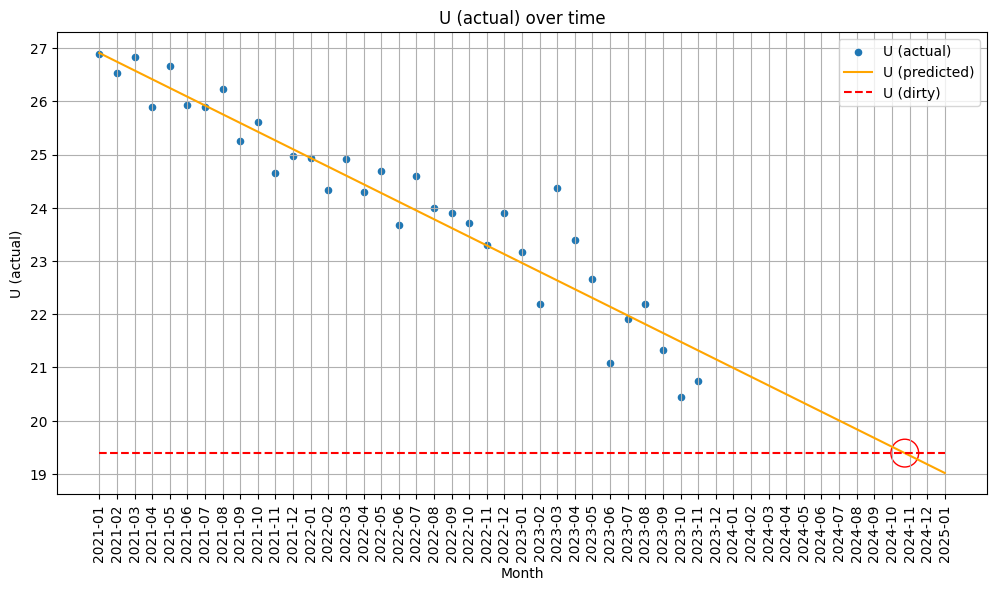

In [26]:
# plot the actual and predicted U values
df_monthly.plot(kind='scatter', x='year-month', y='U (actual)', figsize=(12, 6), title='U (actual) over time')
plt.plot(df_monthly['year-month'], df_monthly['U (predicted)'], color='orange')
plt.plot(df_monthly['year-month'], [u_dirty] * len(df_monthly), color='red', linestyle='dashed')
plt.scatter(month, u_dirty, color='red', marker='o', s=400, facecolors='none')
plt.xlabel('Month')
plt.xticks(rotation=90)
plt.legend(['U (actual)', 'U (predicted)', 'U (dirty)'])
plt.grid()
plt.show()


<h3>Conclusion?</h3>

<hr style="margin-top: 4rem;">
<h2>Author</h2>

<a href="https://github.com/SamerHany">Samer Hany</a>

<h2>References</h2>
<a href="https://www.w3schools.com/python/default.asp">w3schools.com</a>